# Table of Content
* [Read-CSV](#Read-CSV)
* [Helper-Functions](#Helper-Functions)
  * [Helper-function-1:-Generic-Modelling-Fuction](#Helper-function-1:-Generic-Modelling-Fuction)
  * [Helper-function-2:--Evaluation](#Helper-function-2:--Evaluation)
* [Split-training-set-and-test-set](#Split-training-set-and-test-set)
* [Categorical-variables-handling](#Categorical-variables-handling)
* [Numeric-variables-handing](#Numeric-variables-handing)
* [Feature-Assembler-to-combine-categorical-and-numeric-features](#Feature-Assembler-to-combine-categorical-and-numeric-features)
* [Logistic-Regression-fitting](#Logistic-Regression-fitting)
  * [Training-Summary](#Training-Summary)
  * [Prediction-on-test-set](#Prediction-on-test-set)
* [Decision-Tree-fitting](#Decision-Tree-fitting)
* [Random-Forest-fitting](#Random-Forest-fitting)
* [Compare-3-models](#Compare-3-models)
* [Hyperparameter-Tuning-of-Logistic-Regression](#Hyperparameter-Tuning-of-Logistic-Regression)
  * [Observation-of-default-Logistic-Regression-Model-Parameters](#Observation-of-default-Logistic-Regression-Model-Parameters)
  * [Define-pipeline-with-feature-engineering-and-logistic-regression](#Define-pipeline-with-feature-engineering-and-logistic-regression)
  * [Construct-a-grid-of-parameters-to-search-over](#Construct-a-grid-of-parameters-to-search-over)
  * [Configure-Cross-Validator](#Configure-Cross-Validator)
  * [Inspect-Best-Model](#Inspect-Best-Model)
  * [Observation-of-parameters-of-best-model](#Observation-of-parameters-of-best-model)
  * [Use-Best-Model-to-predict-test-set](#Use-Best-Model-to-predict-test-set)
  * [Compare-with-previous-Logistic-Regression](#Compare-with-previous-Logistic-Regression)
* [Inspect-Logistic-Regression-Model-Coefficients](#Inspect-Logistic-Regression-Model-Coefficients)
  * [Get-coefficient-vector-from-logistic-regression-model](#Get-coefficient-vector-from-logistic-regression-model)
  * [Look-for-the-feature-vector-indexes-of-10-largest-and-smallest-coefficients](#Look-for-the-feature-vector-indexes-of-10-largest-and-smallest-coefficients)
  * [Look-at-how-the-feature-vector-been-created](#Look-at-how-the-feature-vector-been-created)
  * [Using-onle-emp_title-for-training](#Using-onle-emp_title-for-training)
  * [Observation](#Observation)

In [1]:
import org.apache.spark.ml.feature.{StringIndexer, OneHotEncoderEstimator, MinMaxScaler, VectorAssembler}
import org.apache.spark.ml.{Pipeline, PipelineModel, PipelineStage}

import org.apache.spark.sql._

import org.apache.spark.ml.classification.{LogisticRegression, LogisticRegressionModel}
import org.apache.spark.ml.classification.{DecisionTreeClassifier, DecisionTreeClassificationModel}
import org.apache.spark.ml.classification.{RandomForestClassifier, RandomForestClassificationModel}

import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator

Intitializing Scala interpreter ...

Spark Web UI available at http://7aceb35ad0ee:4040
SparkContext available as 'sc' (version = 2.4.3, master = local[*], app id = local-1560160243955)
SparkSession available as 'spark'


import org.apache.spark.ml.feature.{StringIndexer, OneHotEncoderEstimator, MinMaxScaler, VectorAssembler}
import org.apache.spark.ml.{Pipeline, PipelineModel, PipelineStage}
import org.apache.spark.sql._
import org.apache.spark.ml.classification.{LogisticRegression, LogisticRegressionModel}
import org.apache.spark.ml.classification.{DecisionTreeClassifier, DecisionTreeClassificationModel}
import org.apache.spark.ml.classification.{RandomForestClassifier, RandomForestClassificationModel}
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator


# Read CSV

Also invert the label
* 1: bad loan
* 0: good loan

In [2]:
val invertLabel = udf((v: Int) => v match {
    case 0 => 1
    case 1 => 0
})

invertLabel: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,IntegerType,Some(List(IntegerType)))


In [3]:
val df = spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load("LCLoan_Wrangled.csv")
  .withColumn("loan_status",invertLabel($"loan_status"))                // inverting the label, now 1 indicates bad loan
  .withColumn("label",col("loan_status"))                               // update the column name to label, to be used in ML models
  .drop("loan_status")                                                  // drop the original column used as label

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 63 more fields]


# Helper Functions

## Helper function 1: Generic Modelling Fuction
The function will accept inputs to determine the appropriate Models, options are:
* logistic regression
* decision tree
* random forest

In [4]:
def runModel (df: DataFrame, 
              modelType: String, 
              threshold: Double = 0.5, 
              weighted: Boolean = false,
              maxIter: Int = 10,
              regParam: Double = 0.0,
              featureEngineeringPipeline: Array[org.apache.spark.ml.PipelineStage]) : PipelineModel = {
        
    val pipelineOrder: Array[org.apache.spark.ml.PipelineStage] = 
    
    //depending on the model chosen,
    if (modelType == "lr"){
        //logistic regression option
       featureEngineeringPipeline :+
            new LogisticRegression()
                .setMaxIter(maxIter)
                .setRegParam(regParam)
                .setThreshold(threshold)
    }
    else if (modelType == "dt"){
        //decision tree option
        featureEngineeringPipeline :+
            new DecisionTreeClassifier()
                  .setLabelCol("label")
                  .setFeaturesCol("features")
    }
    else if (modelType == "rf"){
        //random forest option
        featureEngineeringPipeline :+
            new RandomForestClassifier()
                  .setLabelCol("label")
                  .setFeaturesCol("features")
    }
    else {
        featureEngineeringPipeline
    }    

    //set the pipeline for the model
    val pipeline = new Pipeline()
        .setStages(pipelineOrder)
    
    //return a model fitted on the dataframe
    return pipeline.fit(df)
}

runModel: (df: org.apache.spark.sql.DataFrame, modelType: String, threshold: Double, weighted: Boolean, maxIter: Int, regParam: Double, featureEngineeringPipeline: Array[org.apache.spark.ml.PipelineStage])org.apache.spark.ml.PipelineModel


## Helper function 2:  Evaluation

In [5]:
def evaluatePrediction(prediction: DataFrame) = {
    prediction.createOrReplaceTempView("prediction")
    
    spark.sql("""
select label,prediction,count(1) from prediction group by label,prediction
""").show(false)
    
    spark.sql("""
select 
round((TP+TN)/(P+N),2) as Accuracy,
round(TP/(TP+FP),2) as Precision,
round(TP/(TP+FN),2) as Recall,
round(2*TP/(2*TP+FP+FN),2) as F1,
round(TP/(TP+FN),2) as TPR,
round(FP/(TN+FP),2) as FPR,
round(TN/(TN+FP),2) as TNR,
round(FN/(TP+FN),2) as FNR
from (
    select 
    count(1) as total, 
    sum(case when label = 1 and prediction = 1 then 1 else 0 end) as TP,
    sum(case when label = 0 and prediction = 0 then 1 else 0 end) as TN,
    sum(case when label = 0 and prediction = 1 then 1 else 0 end) as FP,
    sum(case when label = 1 and prediction = 0 then 1 else 0 end) as FN,
    sum(case when label = 1 then 1 else 0 end) as P,
    sum(case when label = 0 then 1 else 0 end) as N
    from prediction
    )
""").show(false)
}

evaluatePrediction: (prediction: org.apache.spark.sql.DataFrame)Unit


# Split training set and test set

In [6]:
val Array(trainingData, testData) = df.randomSplit(Array(0.8, 0.2), seed = 1234L)

trainingData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 63 more fields]
testData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 63 more fields]


In [7]:
testData.count

2019-06-10 09:51:59,274 WARN  [Thread-4] util.Utils (Logging.scala:logWarning(66)) - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


res0: Long = 3967


In [8]:
trainingData.count

res1: Long = 16103


# Categorical variables handling

In [9]:
/*
 * Generate a list of categorical columns
 */

val categoricalColumns = df.dtypes.filter(column => column._2 == "StringType").map(_._1)

categoricalColumns: Array[String] = Array(term, grade, sub_grade, emp_title, emp_length, home_ownership, verification_status, issue_d, purpose, title, zip_code, addr_state, earliest_cr_line, initial_list_status, last_pymnt_d, last_credit_pull_d, application_type)


In [10]:
/*
 * Create 2 transformer for categorical columns
 */

val categoricalFeatures = categoricalColumns.flatMap{ name =>
    
    val stringIndexer = new StringIndexer()
      .setInputCol(name)
      .setOutputCol(name + "_index")
      .setHandleInvalid("keep")
    
    val oneHotEncoder = new OneHotEncoderEstimator()
      .setInputCols(Array(name + "_index"))
      .setOutputCols(Array(name + "_vec"))
      .setDropLast(false)
    
    Array(stringIndexer, oneHotEncoder)
}

categoricalFeatures: Array[org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Model[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Transformer with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature...


# Numeric variables handing

In [11]:
/*
 * Generate a list of categorical columns
 * 
 * Dropping the label, otherwise will get model 100% correct
 */

val numericColumns = df.dtypes.filter(column => column._2 == "IntegerType" || column._2 == "DoubleType").map(_._1)
                    .filterNot( c => c == "label" )

numericColumns: Array[String] = Array(loan_amnt, int_rate, annual_inc, dti, delinq_2yrs, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, total_pymnt, total_rec_int, total_rec_late_fee, collection_recovery_fee, last_pymnt_amnt, collections_12_mths_ex_med, policy_code, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, num_accts_ever_120_pd, num_actv_rev_tl, num_bc_sats, num_il_tl, num_rev_accts, num_sats, num_tl_120dpd_2m, num_tl_90g_dpd_24m, num_tl_op_past_12m, pct_tl_nvr_dlq, percent_bc_gt_75, pub_rec_bankruptcies, tax_liens, tot_hi_cred_lim, total_il_high_credit_limit)


In [12]:
val numericColumnsAssembler = new VectorAssembler()
  .setInputCols(numericColumns)
  .setOutputCol("numerical_features")

numericColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_6b3f2a348d39


In [15]:
val numericColumnsScaler = new MinMaxScaler()
      .setInputCol("numerical_features")
      .setOutputCol("numerical_features" + "_vec")

numericColumnsScaler: org.apache.spark.ml.feature.MinMaxScaler = minMaxScal_f56622a8e097


In [16]:
categoricalFeatures ++ Array(numericColumnsAssembler,numericColumnsScaler)

res2: Array[org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable}}] = Array(strIdx_36080a16bfcb, oneHotEncoder_2a92ba597fd6, strIdx_05d9224e355f, oneHotEncoder_9ddbd7ab4717, strIdx_3eaa3319bcad, oneHotEncoder_90fbf3de28ae, strIdx_1575787794ad, oneHotEncoder_6fc8ded6097e, strIdx_b219abf4541e, oneHotEncoder_062be98abab9, strIdx_3de2a1bb0850, oneHotEncoder_cd2d03d17b33, strIdx_db9af7d784d9, oneHotEncoder_d2c09a01ed1c, strIdx_779b15705c30, oneHotEncoder_178c585552ac, strIdx_62a9539c807...

# Feature Assembler to combine categorical and numeric features

In [17]:
val allFeatureColumns = categoricalColumns.map(x => x + "_vec") :+ "numerical_features_vec"
val featureColumnsAssembler = new VectorAssembler()
  .setInputCols(allFeatureColumns)
  .setOutputCol("features")

allFeatureColumns: Array[String] = Array(term_vec, grade_vec, sub_grade_vec, emp_title_vec, emp_length_vec, home_ownership_vec, verification_status_vec, issue_d_vec, purpose_vec, title_vec, zip_code_vec, addr_state_vec, earliest_cr_line_vec, initial_list_status_vec, last_pymnt_d_vec, last_credit_pull_d_vec, application_type_vec, numerical_features_vec)
featureColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_c7290ec52307


In [18]:
var featureEngineeringPipeline = Array[org.apache.spark.ml.PipelineStage]()
featureEngineeringPipeline = featureEngineeringPipeline ++ categoricalFeatures
featureEngineeringPipeline = featureEngineeringPipeline ++ Array(numericColumnsAssembler,numericColumnsScaler)
featureEngineeringPipeline = featureEngineeringPipeline ++ Array(featureColumnsAssembler)

featureEngineeringPipeline: Array[org.apache.spark.ml.PipelineStage] = Array(strIdx_36080a16bfcb, oneHotEncoder_2a92ba597fd6, strIdx_05d9224e355f, oneHotEncoder_9ddbd7ab4717, strIdx_3eaa3319bcad, oneHotEncoder_90fbf3de28ae, strIdx_1575787794ad, oneHotEncoder_6fc8ded6097e, strIdx_b219abf4541e, oneHotEncoder_062be98abab9, strIdx_3de2a1bb0850, oneHotEncoder_cd2d03d17b33, strIdx_db9af7d784d9, oneHotEncoder_d2c09a01ed1c, strIdx_779b15705c30, oneHotEncoder_178c585552ac, strIdx_62a9539c8070, oneHotEncoder_401665d3a1f6, strIdx_b87c4ce83347, oneHotEncoder_7619c2a53d1a, strIdx_e44ba3543fe0, oneHotEncoder_a62c588035a3, strIdx_f2c94c452e05, oneHotEncoder_8ae57062abc8, strIdx_cea5916ddf2e, oneHotEncoder_b4c80707ab4d, strIdx_8d05847e7b48, oneHotEncoder_667c243f2430, strIdx_5f555f3c5fc4, oneHotEncoder...

# Logistic Regression fitting

In [19]:
// Fit the logistic regression model 
val lr = runModel(trainingData,"lr",featureEngineeringPipeline = featureEngineeringPipeline)
val lrModel = lr.stages(lr.stages.length-1).asInstanceOf[LogisticRegressionModel]

2019-06-10 09:53:18,847 WARN  [Thread-4] netlib.BLAS (BLAS.java:<clinit>(61)) - Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2019-06-10 09:53:18,848 WARN  [Thread-4] netlib.BLAS (BLAS.java:<clinit>(61)) - Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


lr: org.apache.spark.ml.PipelineModel = pipeline_247ff326d397
lrModel: org.apache.spark.ml.classification.LogisticRegressionModel = LogisticRegressionModel: uid = logreg_6793fed68cd8, numClasses = 2, numFeatures = 9357


## Training Summary

In [20]:
// Extract the summary from the returned LogisticRegressionModel instance trained in the earlier
// example
val trainingSummary = lrModel.binarySummary
val accuracy = trainingSummary.accuracy
val falsePositiveRate = trainingSummary.weightedFalsePositiveRate
val truePositiveRate = trainingSummary.weightedTruePositiveRate
val fMeasure = trainingSummary.weightedFMeasure
val precision = trainingSummary.weightedPrecision
val recall = trainingSummary.weightedRecall
println(s"Accuracy: $accuracy\nFPR: $falsePositiveRate\nTPR: $truePositiveRate\n" +
  s"F-measure: $fMeasure\nPrecision: $precision\nRecall: $recall")

Accuracy: 0.997515990809166
FPR: 0.01363282012848001
TPR: 0.997515990809166
F-measure: 0.9975126637488336
Precision: 0.9975114125092305
Recall: 0.997515990809166


trainingSummary: org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummary = org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummaryImpl@47841915
accuracy: Double = 0.997515990809166
falsePositiveRate: Double = 0.01363282012848001
truePositiveRate: Double = 0.997515990809166
fMeasure: Double = 0.9975126637488336
precision: Double = 0.9975114125092305
recall: Double = 0.997515990809166


In [21]:
val roc = trainingSummary.roc
roc.createOrReplaceTempView("roc")
roc.show()
println(s"areaUnderROC: ${trainingSummary.areaUnderROC}")

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.10615199034981906|
|                 0.0|0.20265379975874548|
|                 0.0| 0.2991556091676719|
|                 0.0| 0.3956574185765983|
|                 0.0|0.49215922798552475|
|6.922810661128418E-5| 0.5880579010856454|
|1.384562132225683...| 0.6839565741857659|
|1.384562132225683...| 0.7804583835946924|
|2.769124264451367E-4| 0.8757539203860072|
|3.461405330564209...| 0.9716525934861279|
|0.008653513326410523| 0.9957780458383595|
|0.019522326064382138| 0.9975874547647768|
|0.030529595015576325| 0.9981905910735827|
| 0.04160609207338179| 0.9981905910735827|
| 0.05254413291796469| 0.9993968636911942|
| 0.06362062997577016| 0.9993968636911942|
| 0.07469712703357563| 0.9993968636911942|
| 0.08570439598476981|                1.0|
| 0.09678089304257528|                1.0|
+----------

roc: org.apache.spark.sql.DataFrame = [FPR: double, TPR: double]


In [180]:
! pip install pandas
! pip install matplotlib

   FPR       TPR
0  0.0  0.000000
1  0.0  0.106152
2  0.0  0.202654
3  0.0  0.299156
4  0.0  0.395657


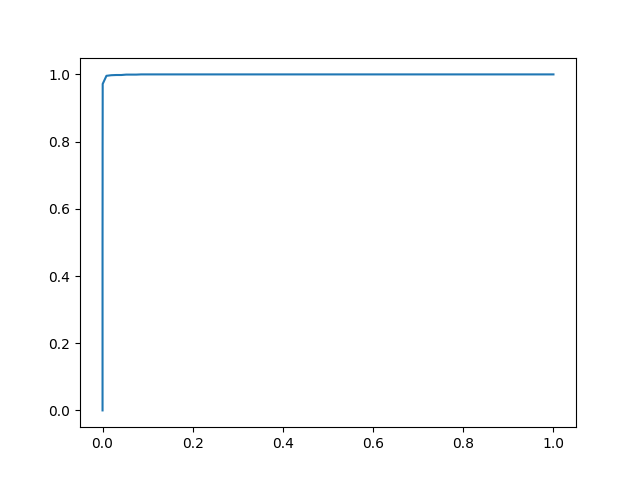

In [22]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

roc = spark.sql("select * from roc")
rocPandas = roc.toPandas()
print(rocPandas.head())
plt.clf()
plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Prediction on test set

In [23]:
val prediction = lr.transform(testData)
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |132     |
|0    |0.0       |3426    |
|1    |1.0       |296     |
|0    |1.0       |113     |
+-----+----------+--------+

+--------+---------+------+----+----+----+----+----+
|Accuracy|Precision|Recall|F1  |TPR |FPR |TNR |FNR |
+--------+---------+------+----+----+----+----+----+
|0.94    |0.72     |0.69  |0.71|0.69|0.03|0.97|0.31|
+--------+---------+------+----+----+----+----+----+



prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 103 more fields]


# Decision Tree fitting

In [24]:
// fitting decision tree model
val dt = runModel(trainingData,"dt",featureEngineeringPipeline = featureEngineeringPipeline)

val model = dt.stages(dt.stages.length-1).asInstanceOf[DecisionTreeClassificationModel]
val prediction = dt.transform(testData)

2019-06-10 09:54:31,787 WARN  [Executor task launch worker for task 432] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_488_0 in memory! (computed 121.0 MB so far)
2019-06-10 09:54:31,791 WARN  [Executor task launch worker for task 432] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_488_0 to disk instead.
2019-06-10 09:54:35,422 WARN  [Executor task launch worker for task 432] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_488_0 in memory! (computed 121.0 MB so far)
2019-06-10 09:54:36,314 WARN  [Executor task launch worker for task 436] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_488_0 in memory! (computed 121.0 MB so far)
2019-06-10 09:54:37,456 WARN  [Executor task launch worker for task 440] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_488_0 in memory! (computed 121.0 MB so far)
2019-06-10 09:54:38,212 WARN  [Ex

dt: org.apache.spark.ml.PipelineModel = pipeline_e164d67d5522
model: org.apache.spark.ml.classification.DecisionTreeClassificationModel = DecisionTreeClassificationModel (uid=dtc_e66149bec95a) of depth 5 with 27 nodes
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 103 more fields]


In [25]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |60      |
|0    |0.0       |3478    |
|1    |1.0       |368     |
|0    |1.0       |61      |
+-----+----------+--------+

+--------+---------+------+----+----+----+----+----+
|Accuracy|Precision|Recall|F1  |TPR |FPR |TNR |FNR |
+--------+---------+------+----+----+----+----+----+
|0.97    |0.86     |0.86  |0.86|0.86|0.02|0.98|0.14|
+--------+---------+------+----+----+----+----+----+



# Random Forest fitting

In [26]:
// fitting random forest model
val rf = runModel(trainingData,"rf",featureEngineeringPipeline = featureEngineeringPipeline)

val model = rf.stages(rf.stages.length-1).asInstanceOf[RandomForestClassificationModel]
val prediction = rf.transform(testData)

2019-06-10 09:55:08,696 WARN  [Executor task launch worker for task 740] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_725_1 in memory! (computed 121.5 MB so far)
2019-06-10 09:55:08,697 WARN  [Executor task launch worker for task 740] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_725_1 to disk instead.
2019-06-10 09:55:11,341 WARN  [Executor task launch worker for task 740] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_725_1 in memory! (computed 79.1 MB so far)
2019-06-10 09:55:11,342 WARN  [Executor task launch worker for task 740] memory.MemoryStore (Logging.scala:logWarning(66)) - Failed to reserve initial memory threshold of 1024.0 KB for computing block broadcast_278 in memory.
2019-06-10 09:55:11,343 WARN  [Executor task launch worker for task 740] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache broadcast_278 in memory! (computed 384.0 B so far)
2019

rf: org.apache.spark.ml.PipelineModel = pipeline_e4db96ed9aab
model: org.apache.spark.ml.classification.RandomForestClassificationModel = RandomForestClassificationModel (uid=rfc_dad95fb6de25) with 20 trees
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 103 more fields]


In [27]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |428     |
|0    |0.0       |3539    |
+-----+----------+--------+

+--------+---------+------+---+---+---+---+---+
|Accuracy|Precision|Recall|F1 |TPR|FPR|TNR|FNR|
+--------+---------+------+---+---+---+---+---+
|0.89    |null     |0.0   |0.0|0.0|0.0|1.0|1.0|
+--------+---------+------+---+---+---+---+---+



# Compare 3 models

| Model| Accuracy | Precision | Recall | F1 | TPR | FPR | TNR | FNR |
|------|------|------|------|------|------|------|------|------|
|   logistic  | 0.94    |0.72     |0.69  |0.71|0.69|0.03|0.97|0.31|
|   decision tree | 0.97    |0.86     |0.86  |0.86|0.86|0.02|0.98|0.14|
|   random forest | 0.89    |0.0     |0.0   |0.0|0.0|0.0|1.0|1.0|

Decistion Tree performs the best. Logistic Regression performs worse than decision tree in all metrics. Particularly, false negative rate of logistic regression is more than double of decistion tree model. Any falst negative imposes a much larger risk to the financial institution than false positive. 

Random forest somehow predicts all test set to be negative, so false negative rate is 100%. That shows random forest is not a good option for imbalance data.

# Hyperparameter Tuning of Logistic Regression

In [28]:
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}

import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}


In [29]:
val lr = new LogisticRegression()

lr: org.apache.spark.ml.classification.LogisticRegression = logreg_eaf94072f63a


In [98]:
lr.	extractParamMap

res55: org.apache.spark.ml.param.ParamMap =
{
	logreg_eaf94072f63a-aggregationDepth: 2,
	logreg_eaf94072f63a-elasticNetParam: 0.0,
	logreg_eaf94072f63a-family: auto,
	logreg_eaf94072f63a-featuresCol: features,
	logreg_eaf94072f63a-fitIntercept: true,
	logreg_eaf94072f63a-labelCol: label,
	logreg_eaf94072f63a-maxIter: 100,
	logreg_eaf94072f63a-predictionCol: prediction,
	logreg_eaf94072f63a-probabilityCol: probability,
	logreg_eaf94072f63a-rawPredictionCol: rawPrediction,
	logreg_eaf94072f63a-regParam: 0.0,
	logreg_eaf94072f63a-standardization: true,
	logreg_eaf94072f63a-threshold: 0.5,
	logreg_eaf94072f63a-tol: 1.0E-6
}


## Observation of default Logistic Regression Model Parameters
* maxIter: 100
* regParam: 0.0
* threshold: 0.5

## Define pipeline with feature engineering and logistic regression

In [30]:
val pipeline = new Pipeline()
  .setStages(featureEngineeringPipeline ++ Array(lr))

pipeline: org.apache.spark.ml.Pipeline = pipeline_f3773d13c132


## Construct a grid of parameters to search over

Total combination to search over: 3 * 4 * 3 = 36

In [31]:
val paramGrid = new ParamGridBuilder()
  .addGrid(lr.maxIter, Array(10,100,1000))
  .addGrid(lr.regParam, Array(0.3, 0.1, 0.01, 0.0))
  .addGrid(lr.threshold, Array(0.4,0.5,0.6))
  .build()

paramGrid: Array[org.apache.spark.ml.param.ParamMap] =
Array({
	logreg_eaf94072f63a-maxIter: 10,
	logreg_eaf94072f63a-regParam: 0.3,
	logreg_eaf94072f63a-threshold: 0.4
}, {
	logreg_eaf94072f63a-maxIter: 10,
	logreg_eaf94072f63a-regParam: 0.3,
	logreg_eaf94072f63a-threshold: 0.5
}, {
	logreg_eaf94072f63a-maxIter: 10,
	logreg_eaf94072f63a-regParam: 0.3,
	logreg_eaf94072f63a-threshold: 0.6
}, {
	logreg_eaf94072f63a-maxIter: 10,
	logreg_eaf94072f63a-regParam: 0.1,
	logreg_eaf94072f63a-threshold: 0.4
}, {
	logreg_eaf94072f63a-maxIter: 10,
	logreg_eaf94072f63a-regParam: 0.1,
	logreg_eaf94072f63a-threshold: 0.5
}, {
	logreg_eaf94072f63a-maxIter: 10,
	logreg_eaf94072f63a-regParam: 0.1,
	logreg_eaf94072f63a-threshold: 0.6
}, {
	logreg_eaf94072f63a-maxIter: 10,
	logreg_eaf94072f63a-regParam: 0.0...

In [32]:
paramGrid.length

res8: Int = 36


## Configure Cross Validator
* set number of folds = 4, CrossValidator will generate 4 (training, test) dataset pairs, each of which uses 3/4 of the data for training and 1/4 for testing. To evaluate a particular ParamMap, CrossValidator computes the average evaluation metric for the 4 Models produced by fitting the Estimator on the 4 different (training, test) dataset pairs.
* parallelism = 2, evaluate up to 2 parameter settings in parallel

In [33]:
val cv = new CrossValidator()
  .setEstimator(pipeline)
  .setEvaluator(new BinaryClassificationEvaluator)
  .setEstimatorParamMaps(paramGrid)
  .setNumFolds(4)  // Use 3+ in practice
  .setParallelism(2)  // Evaluate up to 2 parameter settings in parallel

cv: org.apache.spark.ml.tuning.CrossValidator = cv_85001ef6fd5c


In [34]:
// Run cross-validation, and choose the best set of parameters.
val cvModel = cv.fit(trainingData)

2019-06-10 09:59:49,124 WARN  [block-manager-slave-async-thread-pool-236] storage.BlockManager (Logging.scala:logWarning(66)) - Asked to remove block broadcast_4305, which does not exist
2019-06-10 09:59:49,125 WARN  [block-manager-slave-async-thread-pool-236] storage.BlockManager (Logging.scala:logWarning(66)) - Asked to remove block broadcast_4305_piece0, which does not exist


cvModel: org.apache.spark.ml.tuning.CrossValidatorModel = cv_85001ef6fd5c


## Inspect Best Model

In [92]:
val bestPipeline = cvModel.bestModel.asInstanceOf[org.apache.spark.ml.PipelineModel]

bestPipeline: org.apache.spark.ml.PipelineModel = pipeline_f3773d13c132


In [95]:
val bestModel = bestPipeline.stages(bestPipeline.stages.length-1).asInstanceOf[LogisticRegressionModel]

bestModel: org.apache.spark.ml.classification.LogisticRegressionModel = LogisticRegressionModel: uid = logreg_eaf94072f63a, numClasses = 2, numFeatures = 9357


In [97]:
bestModel.extractParamMap

res54: org.apache.spark.ml.param.ParamMap =
{
	logreg_eaf94072f63a-aggregationDepth: 2,
	logreg_eaf94072f63a-elasticNetParam: 0.0,
	logreg_eaf94072f63a-family: auto,
	logreg_eaf94072f63a-featuresCol: features,
	logreg_eaf94072f63a-fitIntercept: true,
	logreg_eaf94072f63a-labelCol: label,
	logreg_eaf94072f63a-maxIter: 100,
	logreg_eaf94072f63a-predictionCol: prediction,
	logreg_eaf94072f63a-probabilityCol: probability,
	logreg_eaf94072f63a-rawPredictionCol: rawPrediction,
	logreg_eaf94072f63a-regParam: 0.01,
	logreg_eaf94072f63a-standardization: true,
	logreg_eaf94072f63a-threshold: 0.4,
	logreg_eaf94072f63a-tol: 1.0E-6
}


## Observation of parameters of best model
* maxIter: 100 (default value = 100)
* regParam: 0.01 (default value = 0.0)
* threshold: 0.4 (default value = 0.5)

So the best model selected by Cross Validator actually has different parameters to default LR model

## Use Best Model to predict test set

In [65]:
val prediction = cvModel.transform(testData)

prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 103 more fields]


In [66]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |168     |
|0    |0.0       |3476    |
|1    |1.0       |260     |
|0    |1.0       |63      |
+-----+----------+--------+

+--------+---------+------+----+----+----+----+----+
|Accuracy|Precision|Recall|F1  |TPR |FPR |TNR |FNR |
+--------+---------+------+----+----+----+----+----+
|0.94    |0.8      |0.61  |0.69|0.61|0.02|0.98|0.39|
+--------+---------+------+----+----+----+----+----+



## Compare with previous Logistic Regression

| Model| Accuracy | Precision | Recall | F1 | TPR | FPR | TNR | FNR |
|------|------|------|------|------|------|------|------|------|
|   logistic  | 0.94    |0.72     |0.69  |0.71|0.69|0.03|0.97|0.31|
| cross validation logistic | 0.94    |0.8      |0.61  |0.69|0.61|0.02|0.98|0.39|

It doesn't seem to have hugh improvement.

# Inspect Logistic Regression Model Coefficients

## Get coefficient vector from logistic regression model

In [100]:
val coefficients = lrModel.coefficients.toArray.toList.toDF("coeff")

coefficients: org.apache.spark.sql.DataFrame = [coeff: double]


In [101]:
coefficients.describe().show()

+-------+-------------------+
|summary|              coeff|
+-------+-------------------+
|  count|               9357|
|   mean|-0.4200897660885377|
| stddev|  4.433245901842764|
|    min|-20.190229418363103|
|    max|  85.47951343472026|
+-------+-------------------+



In [102]:
coefficients.createOrReplaceTempView("coeff")

      coeff
0 -0.431518
1  0.166681
2  0.000000
3  0.130699
4 -0.317859


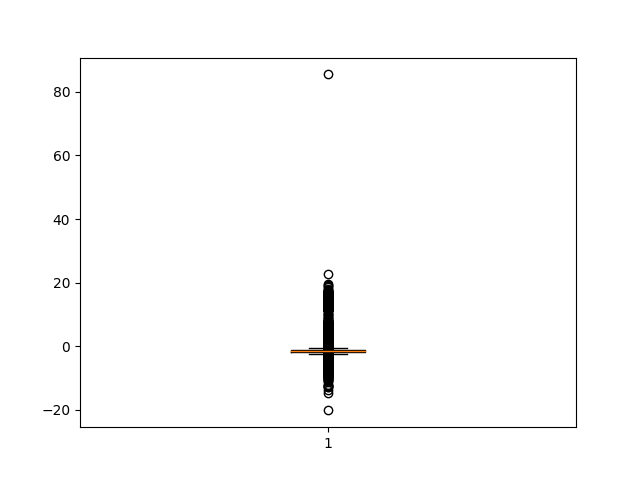

In [103]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

coeff = spark.sql("select * from coeff")
coeffPandas = coeff.toPandas()
print(coeffPandas.head())
plt.clf()
plt.boxplot(coeffPandas['coeff'])
# plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

In [104]:
coefficients.orderBy(desc("coeff")).show(10)

+------------------+
|             coeff|
+------------------+
| 85.47951343472026|
| 22.77081842673796|
|19.469411834911064|
|19.138571952913146|
|18.935964476852543|
|18.505920853921747|
| 17.84811145324859|
|17.648888023555312|
|  17.5211297142109|
| 17.43581356269886|
+------------------+
only showing top 10 rows



In [105]:
coefficients.orderBy(asc("coeff")).show(10)

+-------------------+
|              coeff|
+-------------------+
|-20.190229418363103|
|-14.644224093501567|
|-13.724353138772477|
|-12.848148776111886|
| -12.75263072196487|
|-12.592897227491578|
|-12.410188742154562|
|-12.109321150597998|
| -12.05967456736664|
|-11.162664447977567|
+-------------------+
only showing top 10 rows



## Look for the feature vector indexes of 10 largest and smallest coefficients


In [107]:
val coefficientsArr = lrModel.coefficients.toArray

coefficientsArr: Array[Double] = Array(-0.4315184409697574, 0.16668143479907688, 0.0, 0.1306991843897785, -0.31785925516163815, -0.6666474492595454, 0.4206662845842923, 0.6396571524425809, 0.07006494007137694, 1.2136415758181158, 0.0, 0.04251499355116222, -0.19990422323107324, 0.2968956959691074, -0.20502921915127667, 0.2998066225719562, -0.03434488763289823, 0.3150576843496801, -0.6982980766346993, -0.4260611994672941, -0.1323350657034423, -0.2732812284560593, -0.8867795565670317, -0.18595526654164465, -0.541624012565455, 0.17445177703392956, 0.3973358267884245, 0.8304619932200182, -1.0235564112752698, -0.09176195149526267, 0.4091656752128516, 1.0184517260824413, -0.7283713346518035, 1.3525327054296787, 0.5532308900286937, 1.1966714754052354, -0.4721410700222022, 0.03154260779317063, 1...

In [114]:
val lowestIndex = for { i <- coefficientsArr.zipWithIndex
     if i._1 <= -11.162664447977567} yield i._2

lowestIndex: Array[Int] = Array(1030, 3081, 3165, 4239, 4568, 5350, 5385, 5671, 9322, 9326)


In [113]:
val highestIndex = for { i <- coefficientsArr.zipWithIndex
     if i._1 >= 17.43581356269886} yield i._2

highestIndex: Array[Int] = Array(549, 1733, 1999, 2010, 2144, 4403, 6736, 7409, 9324, 9325)


## Look at how the feature vector been created

In [105]:
allFeatureColumns.foreach{ f =>
    prediction.select(f).show(5,false)
}

+-------------+
|term_vec     |
+-------------+
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
+-------------+
only showing top 5 rows

+-------------+
|grade_vec    |
+-------------+
|(8,[2],[1.0])|
|(8,[2],[1.0])|
|(8,[2],[1.0])|
|(8,[1],[1.0])|
|(8,[1],[1.0])|
+-------------+
only showing top 5 rows

+---------------+
|sub_grade_vec  |
+---------------+
|(36,[11],[1.0])|
|(36,[11],[1.0])|
|(36,[11],[1.0])|
|(36,[5],[1.0]) |
|(36,[7],[1.0]) |
+---------------+
only showing top 5 rows

+-------------------+
|emp_title_vec      |
+-------------------+
|(7715,[7714],[1.0])|
|(7715,[7714],[1.0])|
|(7715,[5418],[1.0])|
|(7715,[616],[1.0]) |
|(7715,[7714],[1.0])|
+-------------------+
only showing top 5 rows

+---------------+
|emp_length_vec |
+---------------+
|(13,[4],[1.0]) |
|(13,[0],[1.0]) |
|(13,[3],[1.0]) |
|(13,[10],[1.0])|
|(13,[0],[1.0]) |
+---------------+
only showing top 5 rows

+------------------+
|home_ownership_vec|
+------------------+
|(

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 5 rows



#### length of feature vector for catogirical variables
```
term_vec: 3
grade_vec: 8
sub_grade_vec: 36
emp_title_vec: 9192
emp_length_vec: 13
home_ownership_vec: 5
verification_status_vec: 4
issue_d_vec: 13
purpose_vec: 13
title_vec: 13
zip_code_vec: 835
addr_state_vec: 51
earliest_cr_line_vec: 563
initial_list_status_vec: 3
last_pymnt_d_vec: 27
last_credit_pull_d_vec: 27
application_type_vec: 3
```

#### numerical vector order

In [106]:
numericColumns.foreach(println)

loan_amnt
int_rate
annual_inc
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
out_prncp
total_pymnt
total_rec_int
total_rec_late_fee
collection_recovery_fee
last_pymnt_amnt
collections_12_mths_ex_med
policy_code
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
acc_open_past_24mths
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
num_accts_ever_120_pd
num_actv_rev_tl
num_bc_sats
num_il_tl
num_rev_accts
num_sats
num_tl_120dpd_2m
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_il_high_credit_limit


In [107]:
numericColumns.length

res30: Int = 47


#### Length of feature vectors = Length of coeff vector
* catogirical var = 3+8+36+9192+13+5+4+13+13+13+835+51+563+3+27+27+3 = 10809
* numeric var = 47
* total = 10809+47 = 10856

All the top 10 largest and smallest coefficients indexes are with the one hot encoder vector range of string field 'emp_title' and 'zip_code'

Now try to feed only emp_title and zip_code field into logistic regression to see what happens

## Using onle emp_title for training

In [116]:
val categoricalFeatures = Array("emp_title","zip_code").flatMap{ name =>
    
    val stringIndexer = new StringIndexer()
      .setInputCol(name)
      .setOutputCol(name + "_index")
      .setHandleInvalid("keep")
    
    val oneHotEncoder = new OneHotEncoderEstimator()
      .setInputCols(Array(name + "_index"))
      .setOutputCols(Array(name + "_vec"))
      .setDropLast(false)
    
    Array(stringIndexer, oneHotEncoder)
}

val allFeatureColumns = Array("emp_title","zip_code").map(x => x + "_vec")
val featureColumnsAssembler = new VectorAssembler()
  .setInputCols(allFeatureColumns)
  .setOutputCol("features")

var featureEngineeringPipeline = Array[org.apache.spark.ml.PipelineStage]()
featureEngineeringPipeline = featureEngineeringPipeline ++ categoricalFeatures
featureEngineeringPipeline = featureEngineeringPipeline ++ Array(featureColumnsAssembler)

categoricalFeatures: Array[org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Model[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Transformer with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature...

In [117]:
// Fit the logistic regression model 
val lr = runModel(trainingData,"lr",featureEngineeringPipeline = featureEngineeringPipeline)
val lrModel = lr.stages(lr.stages.length-1).asInstanceOf[LogisticRegressionModel]

lr: org.apache.spark.ml.PipelineModel = pipeline_2492bf2a41a2
lrModel: org.apache.spark.ml.classification.LogisticRegressionModel = LogisticRegressionModel: uid = logreg_f8090e4d1479, numClasses = 2, numFeatures = 8539


In [118]:
// Evaluate Model
val trainingSummary = lrModel.binarySummary
val accuracy = trainingSummary.accuracy
val falsePositiveRate = trainingSummary.weightedFalsePositiveRate
val truePositiveRate = trainingSummary.weightedTruePositiveRate
val fMeasure = trainingSummary.weightedFMeasure
val precision = trainingSummary.weightedPrecision
val recall = trainingSummary.weightedRecall
println(s"Accuracy: $accuracy\nFPR: $falsePositiveRate\nTPR: $truePositiveRate\n" +
  s"F-measure: $fMeasure\nPrecision: $precision\nRecall: $recall")
val roc = trainingSummary.roc
roc.createOrReplaceTempView("roc")
roc.show()
println(s"areaUnderROC: ${trainingSummary.areaUnderROC}")

val prediction = lr.transform(testData)
evaluatePrediction(prediction)

Accuracy: 0.9414394833260883
FPR: 0.4610774679280538
TPR: 0.9414394833260883
F-measure: 0.9334977194801429
Precision: 0.939254167763662
Recall: 0.9414394833260883
+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.09951749095295537|
|                 0.0|0.23462002412545235|
|                 0.0|0.31544028950542824|
|                 0.0|0.38721351025331724|
|0.001523018345448252|0.43063932448733416|
| 0.00380754586362063| 0.4674306393244873|
|0.007061266874350987|0.49638118214716526|
|0.010384215991692628| 0.5271411338962606|
|0.014053305642090688| 0.5536791314837153|
| 0.01855313257182416| 0.5753920386007237|
|0.022983731394946347|  0.594692400482509|
|0.028175839390792663| 0.6158021712907117|
| 0.03302180685358255| 0.6363088057901085|
|0.038352371062651436| 0.6501809408926418|
|0.043821391484942886| 0.6670687575392038|
| 0.0501211491865697

trainingSummary: org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummary = org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummaryImpl@3482490f
accuracy: Double = 0.9414394833260883
falsePositiveRate: Double = 0.4610774679280538
truePositiveRate: Double = 0.9414394833260883
fMeasure: Double = 0.9334977194801429
precision: Double = 0.939254167763662
recall: Double = 0.9414394833260883
roc: org.apache.spark.sql.DataFrame = [FPR: double, TPR: double]
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 71 more fields]


   FPR       TPR
0  0.0  0.000000
1  0.0  0.099517
2  0.0  0.234620
3  0.0  0.315440
4  0.0  0.387214


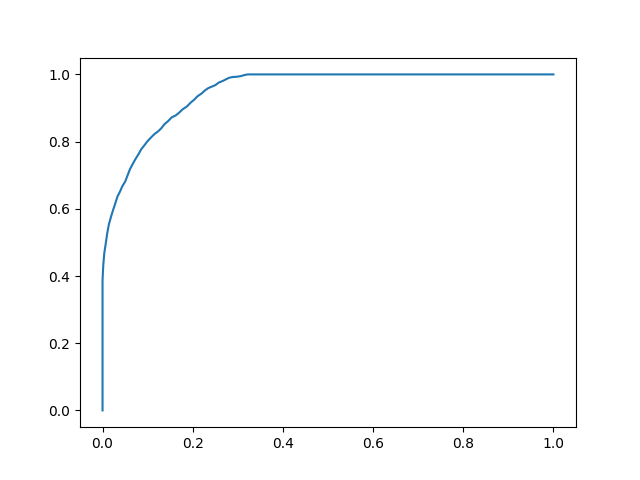

In [119]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

roc = spark.sql("select * from roc")
rocPandas = roc.toPandas()
print(rocPandas.head())
plt.clf()
plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Observation

Using only the `emp_title` field for training still achives good result in training, while model performs poorly in test set:

| Data| Accuracy | Precision | Recall | F1 |
|------|------|------|------|------|
|   Training Set  | 0.94    |0.94     |0.94  |0.93|
|   Test Set | 0.87    |0.16     |0.05  |0.08|


That suggestes the model performs very well on training data but has high error rates on test data, due to the model has
* high variance
* low bias